# Second stage of the OSIOSN project

### Creating and training baseline model

In [1]:
import os
import numpy as np
import torch
from torch import nn, cat
from torch.nn import Conv1d, ConvTranspose1d, MaxPool1d, Dropout, ReLU, Sequential, Sigmoid
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
DATASET_PATH = "./dataset"

In [3]:
x_train = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_train.npy")), -1)[:10000]
y_train = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_train.npy")), -1)[:10000]

x_test = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_test.npy")), -1)[:2500]
y_test = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_test.npy")), -1)[:2500]

x_val = np.expand_dims(np.load(os.path.join(DATASET_PATH, "x_val.npy")), -1)[:1000]
y_val = np.expand_dims(np.load(os.path.join(DATASET_PATH, "y_val.npy")), -1)[:1000]

In [4]:
num_epochs = 20
batch_size = 1
lr = 1e-3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Training will be performed with:',device)

Training will be performed with: cuda:0


In [5]:
# data shape [batch_size, channels, samples]

class Conv1DBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super(Conv1DBlock, self).__init__()
    self.conv1d = Conv1d(in_channels, out_channels, kernel_size, padding="same")
    self.relu = ReLU(inplace=True)

  def forward(self, x):
    x = self.conv1d(x)
    x = self.relu(x)
    return x

class DoubleConv1DBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size):
    super(DoubleConv1DBlock, self).__init__()
    self.double_conv = Sequential(
      Conv1DBlock(in_channels, out_channels, kernel_size),
      Conv1DBlock(out_channels, out_channels, kernel_size)
    )

  def forward(self, x):
    return self.double_conv(x)


class DownSample1DBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, dropout=0.3):
    super(DownSample1DBlock, self).__init__()
    self.double_conv = DoubleConv1DBlock(in_channels, out_channels, kernel_size)
    self.maxpool_1d = MaxPool1d(kernel_size=2)
    self.dropout = Dropout(dropout)

  def forward(self, x):
    x = self.double_conv(x)
    pool = self.maxpool_1d(x)
    return x, self.dropout(pool)


class UpSample1DBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, dropout=0.3):
    super(UpSample1DBlock, self).__init__()
    self.conv1d_transpose = ConvTranspose1d(in_channels, out_channels, kernel_size=2, stride=2)
    self.double_conv = DoubleConv1DBlock(in_channels, out_channels, kernel_size)
    self.dropout = Dropout(dropout)

  def forward(self, x, conv_features):
    x = self.conv1d_transpose(x)
    x = cat([x, conv_features], dim=1)
    x = self.dropout(x)
    return self.double_conv(x)

In [6]:
class ECGDataset(Dataset):
  def __init__(self, data, labels):
    super(ECGDataset, self).__init__()
    self.data = data
    self.labels = labels

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    sample = torch.tensor(self.data[idx], dtype=torch.float32)
    label = torch.tensor(self.labels[idx], dtype=torch.float32)
    return sample, label

In [17]:
class RPNet(nn.Module):
  def __init__(self, in_channels, out_channels, lr=1e-3):
    super(RPNet, self).__init__()
    self.d1 = DownSample1DBlock(in_channels, 16, 3)
    self.d2 = DownSample1DBlock(16, 32, 3)
    self.d3 = DownSample1DBlock(32, 64, 3)

    self.bottleneck = DoubleConv1DBlock(64, 128, 3)
    
    self.u1 = UpSample1DBlock(128, 64, 3)
    self.u2 = UpSample1DBlock(64, 32, 3)
    self.u3 = UpSample1DBlock(32, 16, 3)

    self.output = Conv1d(16, out_channels, kernel_size=1)
    self.sigmoid = Sigmoid()

    self.criterion = nn.BCELoss()
    self.optimizer = Adam(self.parameters(), lr=lr)


  def forward(self, x):
    x = x.transpose(1,2)
    
    f1, p1 = self.d1(x)
    f2, p2 = self.d2(p1)
    f3, p3 = self.d3(p2)
    
    bottleneck = self.bottleneck(p3)

    u1 = self.u1(bottleneck, f3)
    u2 = self.u2(u1, f2)
    u3 = self.u3(u2, f1)

    output = self.output(u3)
    return self.sigmoid(output)
  
  def train_model(self, x_train, y_train, epochs, x_val=None, y_val=None):
    self.train()
    dataset = ECGDataset(x_train, y_train)
    train_loader = DataLoader(dataset, batch_size, shuffle=True)

    for epoch in range(epochs):
      running_loss = 0.0
      print(f"Epoch {epoch + 1}")

      for i, (x, y) in tqdm(enumerate(train_loader), total=x_train.shape[0]):
        self.optimizer.zero_grad()
        outputs = self(x)

        y = y.transpose(1,2) # change from batch_size x samples x channels to batch_size x channels x samples

        loss = self.criterion(outputs, y)
        loss.backward()
        self.optimizer.step()

        running_loss += loss.item()
      
      print("Loss in epoch {:d}: {:.2f}".format((epoch + 1), running_loss))
  
  def validate(self, x_val, y_val):
    running_vloss = 0.0
    self.eval()

    validation_dataset = ECGDataset(x_val, y_val)
    validation_loader = DataLoader(validation_dataset, batch_size=2, shuffle=True)

    with torch.no_grad():
      for i, (x_val, y_val) in enumerate(validation_loader):
        outputs = self(x_val)

        y_val = y_val.transpose(1,2)

        loss = self.criterion(outputs, y_val)
        running_vloss += loss.item()

    print("Validation loss: {:.2f}".format(running_vloss))

In [18]:
model = RPNet(in_channels=1, out_channels=1)

In [19]:
model.train_model(x_train=x_train, y_train=y_train, epochs=1, x_val=x_val, y_val=y_val)

Epoch 1


100%|██████████| 10000/10000 [04:22<00:00, 38.06it/s]

Loss in epoch 1: 60.40


In [10]:
def test(model, x_test, y_test):
  running_loss = 0.0
  
  model.eval()

  test_dataset = ECGDataset(x_test, y_test)
  test_loader = DataLoader(test_dataset)

  with torch.no_grad():
    for i, (x_test, y_test) in enumerate(test_loader):
      outputs = model(x_test)
      
      y_test = y_test.transpose(1,2)

      loss = model.criterion(outputs, y_test)

      running_loss += loss

      if i % 250 == 0:
        y_test = np.transpose(y_test[0])
        outputs = torch.Tensor.numpy(outputs[0])
        outputs = np.transpose(outputs)

        plt.figure(figsize=(10,10))
        plt.subplot(3,1,1)
        plt.plot(x_test[0])
        plt.grid()
        plt.title("ECG")
        plt.subplot(3,1,2)
        plt.plot(y_test)
        plt.grid()
        plt.title("Y true")
        plt.subplot(3,1,3)
        plt.plot(outputs)
        plt.grid()
        plt.title("Y pred")
        plt.show()
  
  print("Test loss: {:.2f}".format(running_loss))

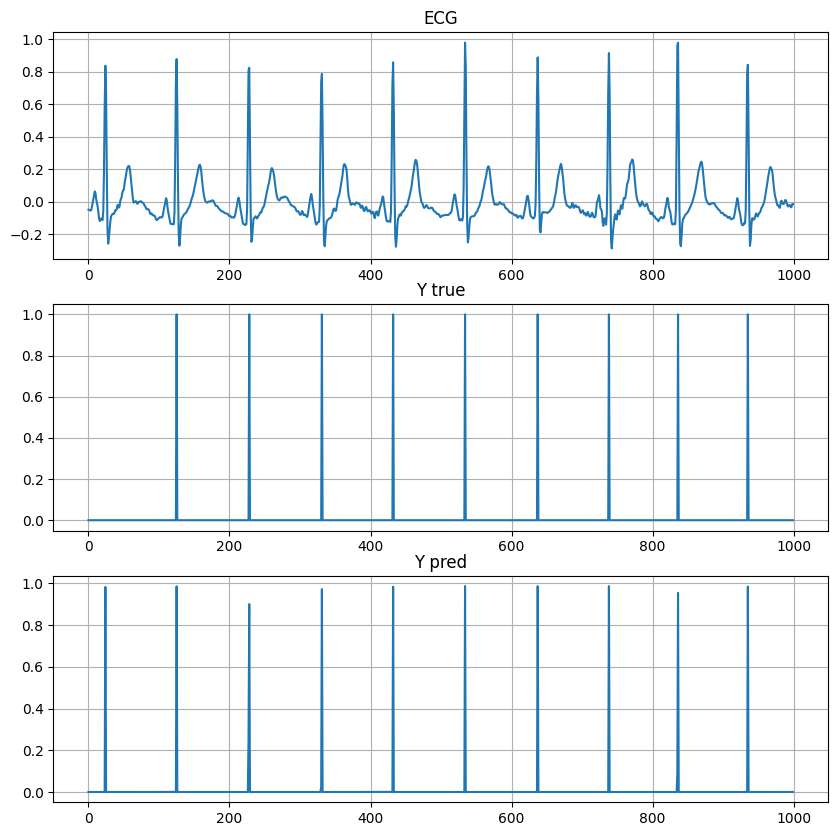

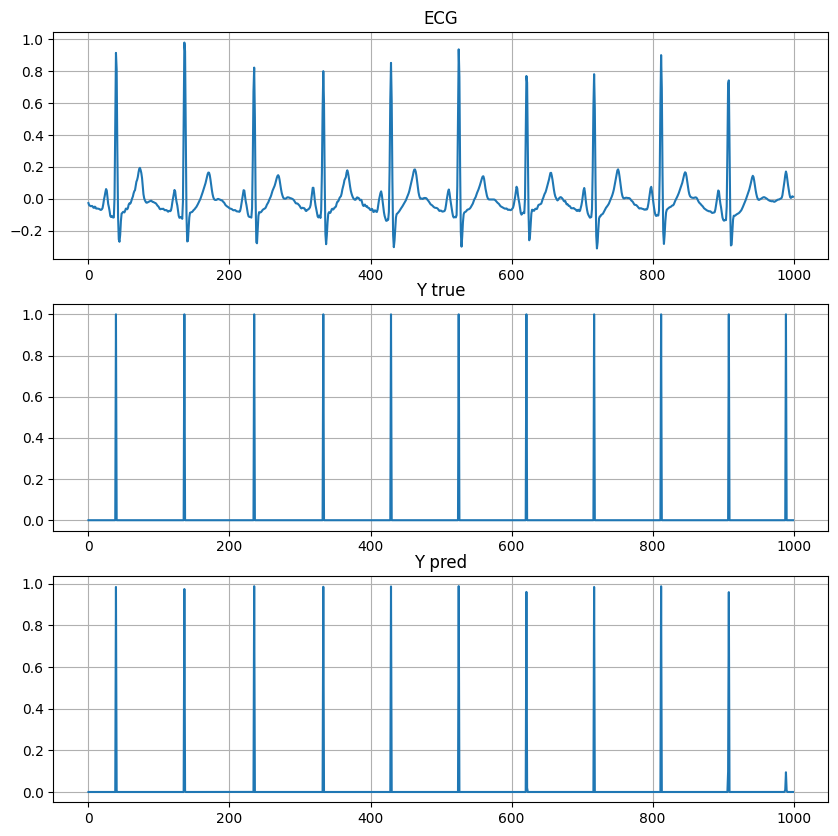

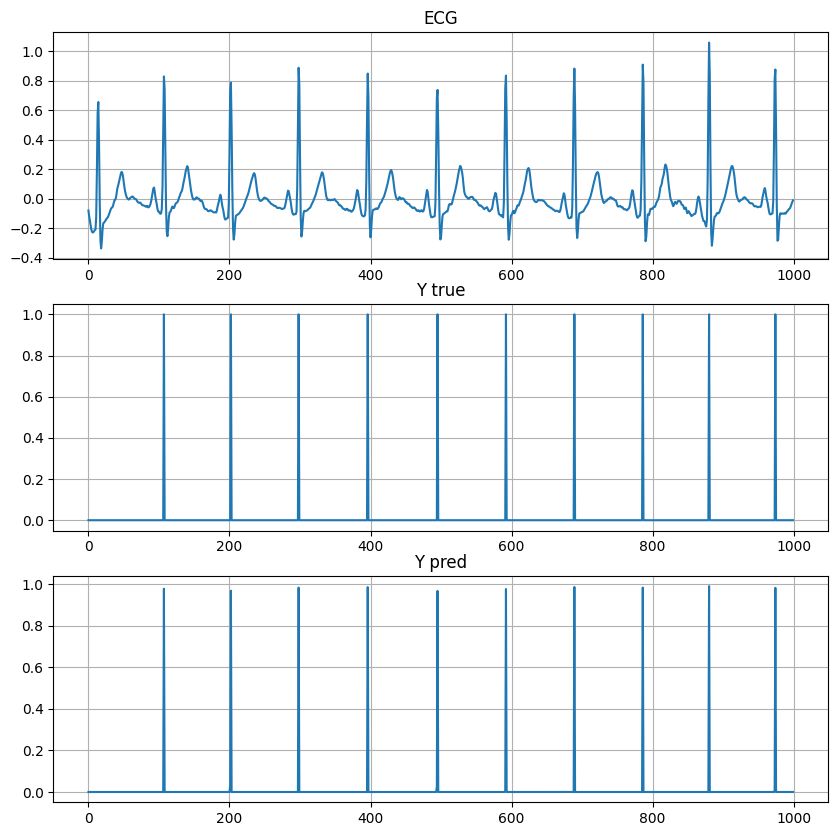

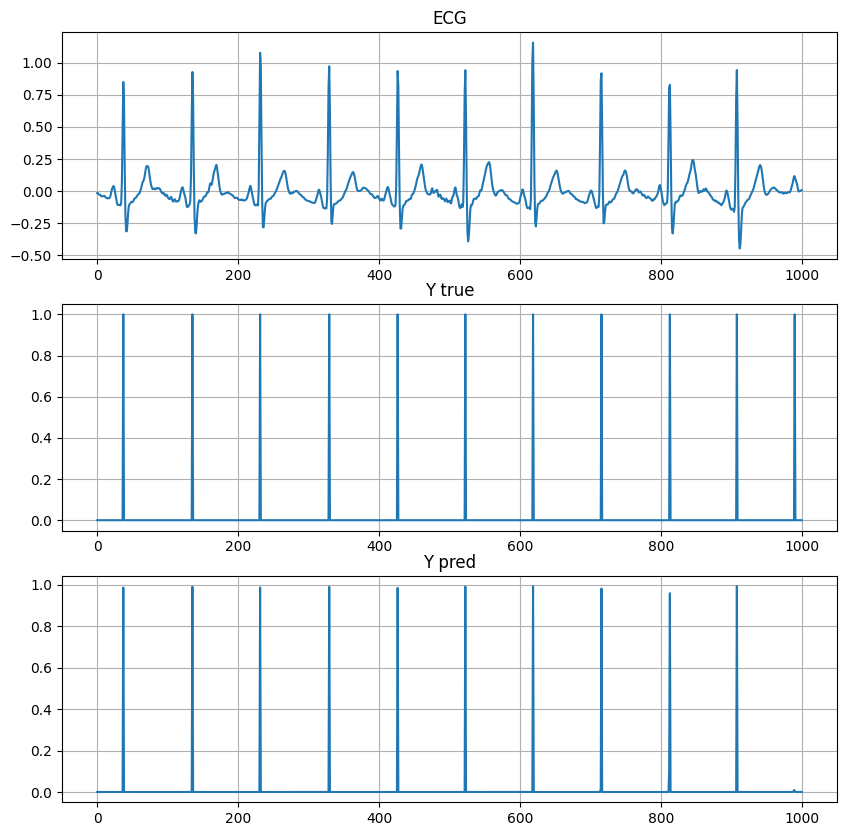

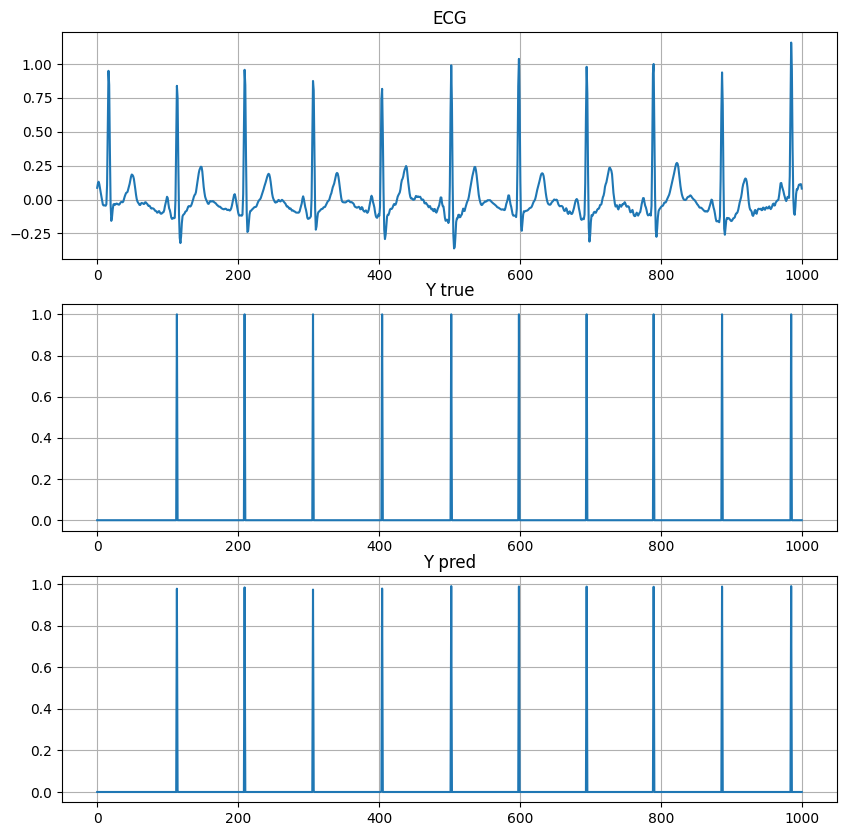

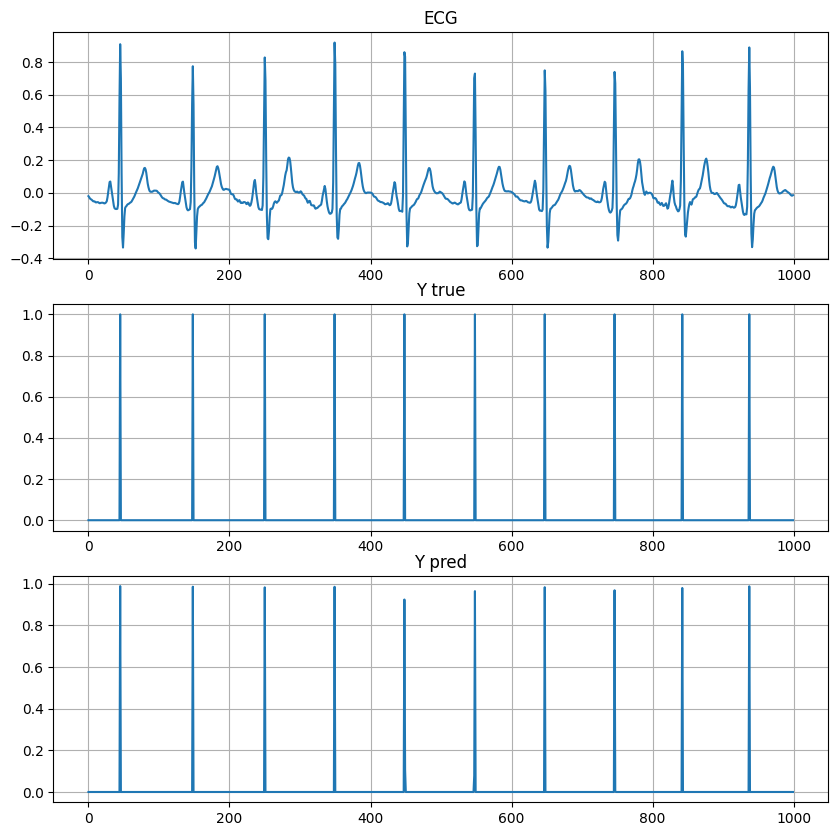

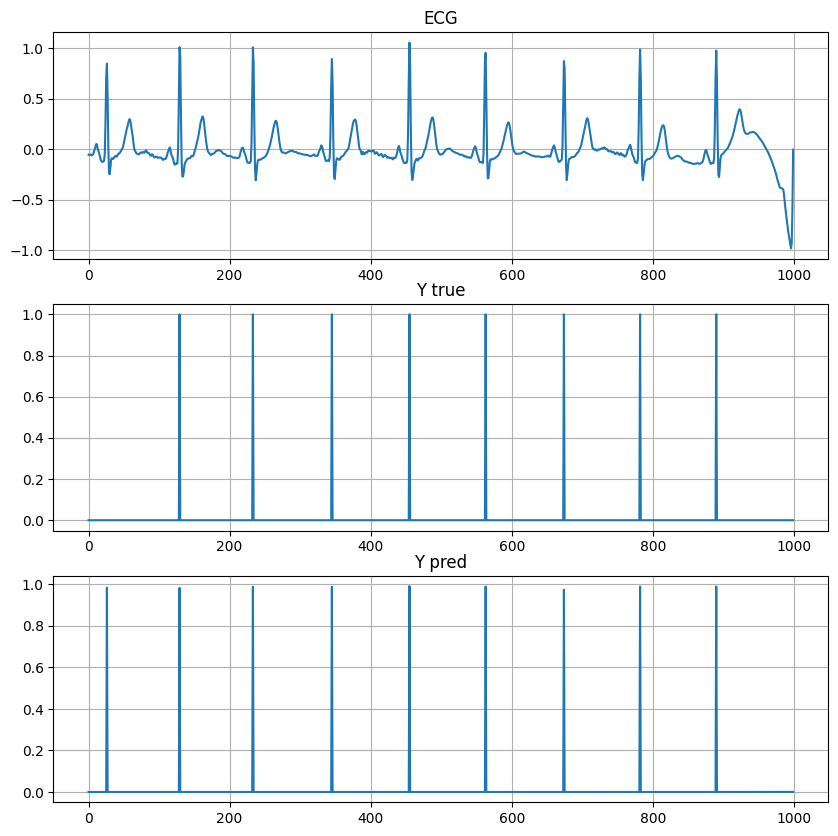

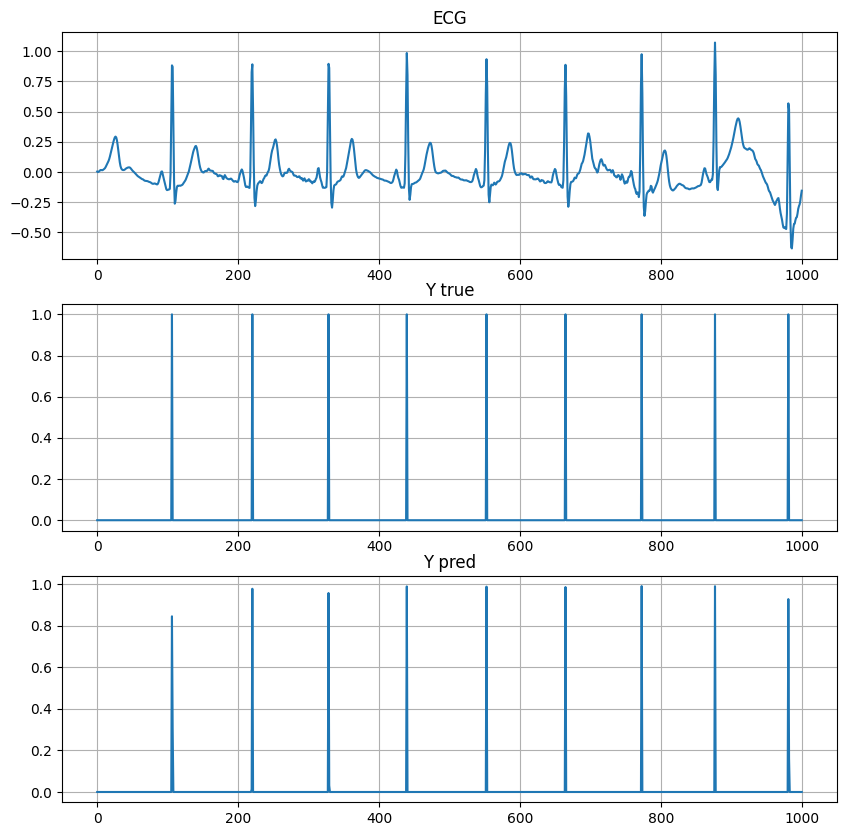

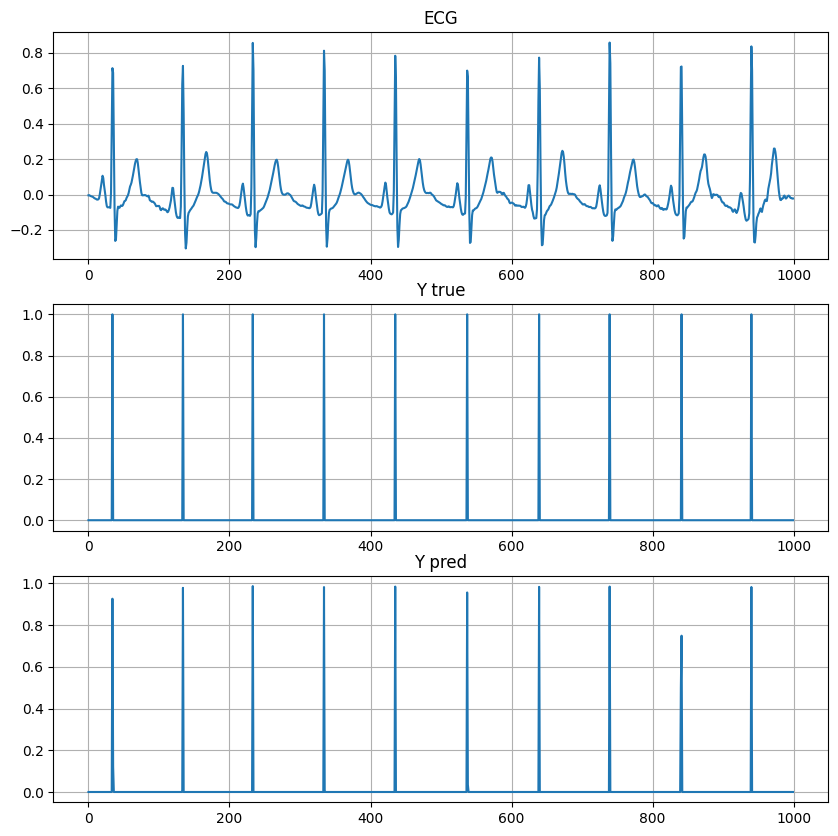

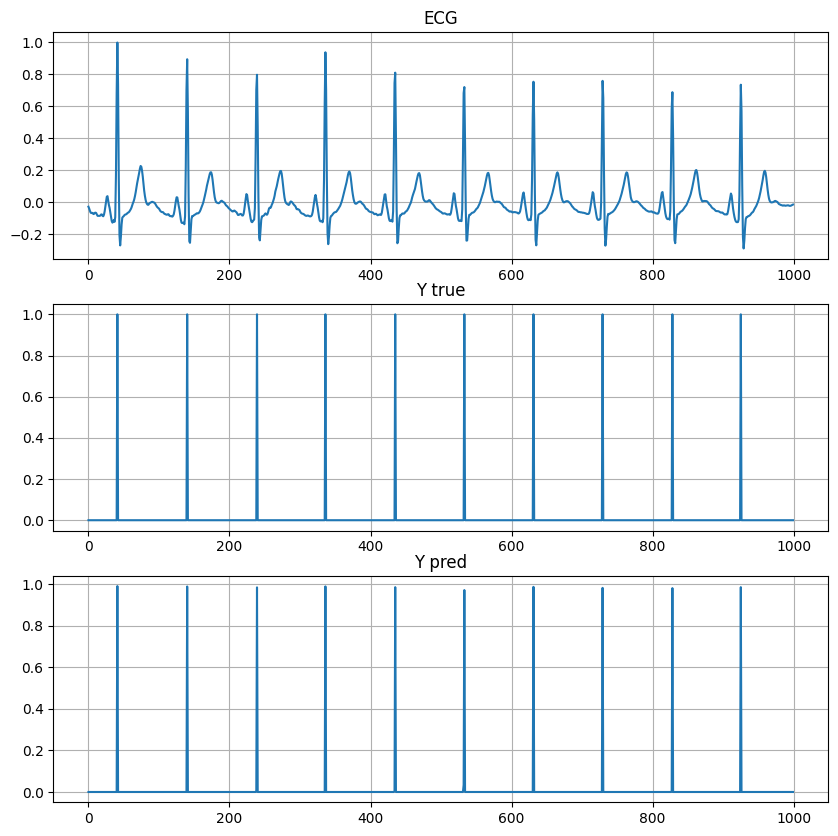

Test loss: 3.83


In [20]:
test(model, x_test, y_test)